In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Vamos carregar os conjuntos de treinamento, teste e os metadados
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters', 
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

In [15]:
# Pela saída podemos ver que nao temos todas as letras representadas, sera refletido na matriz de confusao
counts = np.zeros(26, dtype=int)
for _, labels in ds_test:
    counts[labels.numpy()] += 1
print("Distribuição de classes no teste:", counts)

Distribuição de classes no teste: [  0 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800
 800 400   0   0   0   0   0   0]


In [16]:
# Explorar metadados
print("=== INFORMAÇÕES DO DATASET ===")
print(f"Nome: {ds_info.name}")
print(f"Descrição: {ds_info.description}")
print(f"Tamanho do train: {ds_info.splits['train'].num_examples}")
print(f"Tamanho do test: {ds_info.splits['test'].num_examples}")
print(f"Classes: {ds_info.features['label'].num_classes}")

=== INFORMAÇÕES DO DATASET ===
Nome: emnist
Descrição: The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
Tamanho do train: 88800
Tamanho do test: 14800
Classes: 37


In [17]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label - 1
ds_train = ds_train.map(normalize_img).shuffle(1024).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize_img).batch(128).prefetch(tf.data.AUTOTUNE)

2025-09-14 21:00:38.217998: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


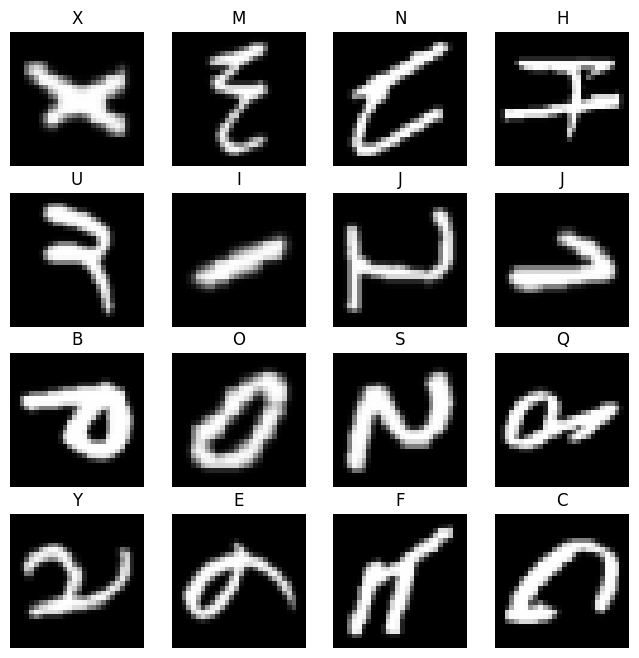

2025-09-14 21:00:38.802860: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
for images, labels in ds_train.take(1):
    plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(tf.squeeze(images[i]), cmap="gray")
        plt.title(chr(labels[i].numpy() + 65))
        plt.axis("off")
    plt.show()

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

/home/Projetos/miniconda3/envs/eminist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Escolhemos o otimizador, a loss function e a metrica de avaliacao

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# Treinamento ocorre aplicando backpropagation em cada batch do conjunto de treino.

# Durante o treino, o modelo calcula loss e accuracy nos batches de treino.

#Ao final de cada época, o modelo é avaliado no conjunto de validação/teste
#para medir generalização, comparando previsões com os rótulos reais.

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test
)

Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.8002 - loss: 0.6610 - val_accuracy: 0.8715 - val_loss: 0.3908
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9047 - loss: 0.2982 - val_accuracy: 0.8974 - val_loss: 0.3130
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9210 - loss: 0.2405 - val_accuracy: 0.8979 - val_loss: 0.2958
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.9302 - loss: 0.2070 - val_accuracy: 0.9095 - val_loss: 0.2727
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9378 - loss: 0.1843 - val_accuracy: 0.9139 - val_loss: 0.2536
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9440 - loss: 0.1636 - val_accuracy: 0.9091 - val_loss: 0.2701
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9476 - loss: 0.1489 - val_accuracy: 0.9115 - val_loss: 0.2717
Epoch 8/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9517 - loss: 0.1331 - 

In [23]:
test_loss, test_acc = model.evaluate(ds_test)
print("Acurácia no teste:", test_acc)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9120 - loss: 0.2851
Acurácia no teste: 0.9119594693183899


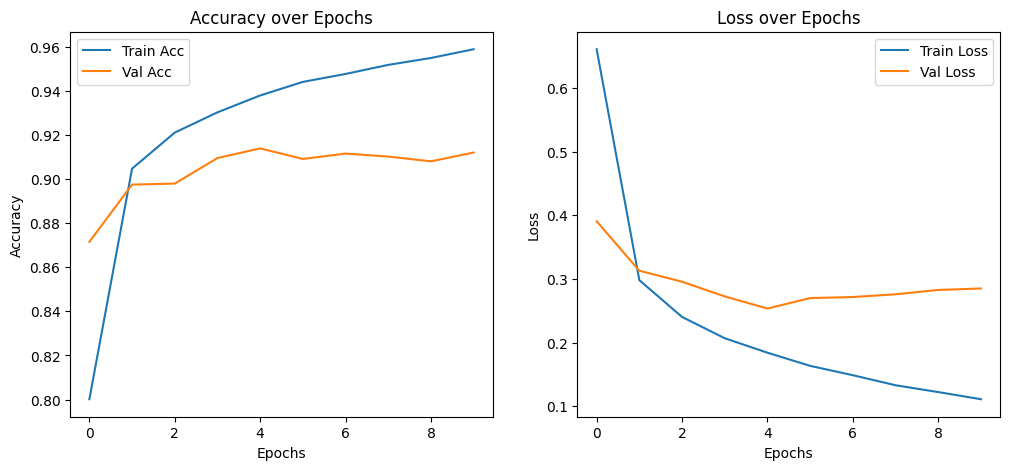

In [24]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

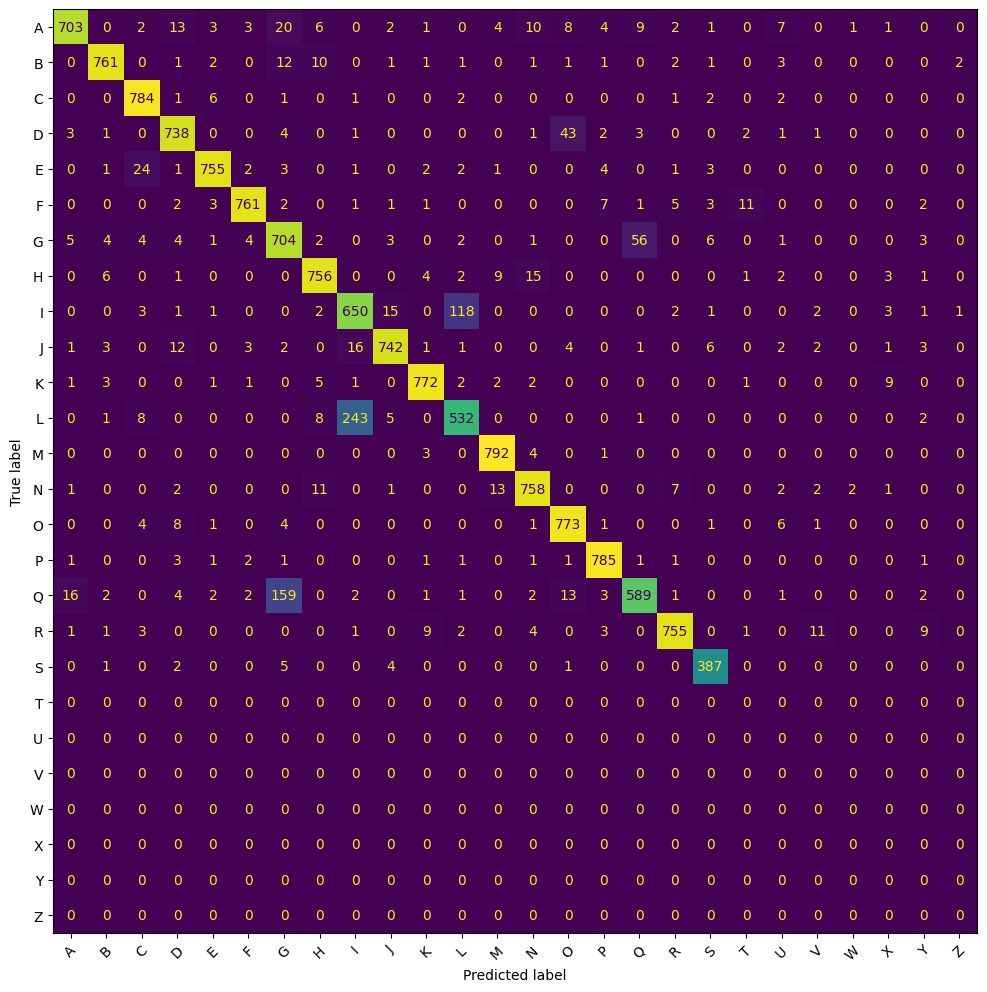

In [25]:
# Apresentacao da matriz de confusao, como nao usamos todo o conjuto de dados
# algumas letras nao

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[chr(i+65) for i in range(26)]
    )
disp.plot(cmap='viridis', xticks_rotation=45, ax=ax, colorbar=False)
plt.show()